# 0. Imports

In [2]:
# for data handling and manipulation:
import pandas as pd
import numpy as np

# for os handling
import os

# for pre-processing
from sklearn.preprocessing import StandardScaler

# import the classifiers to fit:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# import metrics
from sklearn.metrics import fbeta_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay, make_scorer

# for tabulating results
from tabulate import tabulate

# for visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# for handling warnings
import warnings

# for hyper-parameter tuning
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.model_selection import GridSearchCV

In [3]:
# Reading the train, test and validation data into this notebook 

X_train_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_train_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_train_gray = X_train_gray.to_numpy()

y_train = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_train.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_train = y_train.to_numpy(dtype = 'int64').flatten()

X_val_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_val_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_val_gray = X_val_gray.to_numpy()

y_val = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_val.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_val = y_val.to_numpy(dtype = 'int64').flatten()

X_test_gray = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\X_test_gray.csv').drop(columns = ['Unnamed: 0'], axis = 1)
X_test_gray = X_test_gray.to_numpy()

y_test = pd.read_csv(r'D:\CMI LOCAL\PROJECTS\ML Project\Prepared data\y_test.csv').drop(columns = ['Unnamed: 0'], axis = 1)
y_test = y_test.to_numpy(dtype = 'int64').flatten()

In [4]:
X_train_gray.shape, y_train.shape, X_val_gray.shape, y_val.shape, X_test_gray.shape, y_test.shape

((791, 98), (791,), (98, 98), (98,), (100, 98), (100,))

In [5]:
X_final_train_gray = np.concatenate((X_train_gray, X_val_gray), axis = 0)
y_train_final = np.concatenate((y_train, y_val), axis = 0)

## Function to calculate metrics

In [6]:
def calculate_metrics(y_pred, y_true, normalize = False):
    
    with warnings.catch_warnings():
        
        warnings.filterwarnings('ignore')
        # calculate accuracy:
        temp = round(accuracy_score(y_true, y_pred),2)
        print('Accuracy in detecting Accident class: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')
        
        my_data = []
        cr = classification_report(y_true, y_pred, output_dict = True)

        # calculate precision:
        my_data.append(['Precision',round(cr['0']['precision'],2), round(cr['1']['precision'],2)])

        # calculate recall:
        my_data.append(['Recall',round(cr['0']['recall'],2), round(cr['1']['recall'],2)])

        # f1-score:
        my_data.append(['f1-score',round(cr['0']['f1-score'],2), round(cr['1']['f1-score'],2)])

        head = ['Metric','Non-Accident images','Accident images']

        print(tabulate(my_data, headers = head, tablefmt = 'grid'))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate sensitivity (recall of positive class for binary classification)
        temp = round(cr['1']['recall'],2)
        print('Sensitivity/ ability to correctly classifiy to Accident class is: {}'.format(temp))
    
        # calculate specificity (recall of negative class for binary classification)
        temp = round(cr['0']['recall'],2)
        print('Specificity/ ability to correctly classifiy to Non-Accident class is: {}'.format(temp))
        print('\n------------------------------------------------------------------------------------------\n')

        # calculate f1-beta score:
        print('Fbeta score with beta = 1.5 is: {}'.format(round(fbeta_score(y_true, y_pred,beta = 1.4),2)))
        print('\n------------------------------------------------------------------------------------------\n')

        # Confusion matrix:

        if normalize == False:
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')
        else:
            cm = confusion_matrix(y_true, y_pred, normalize='all')
            disp = ConfusionMatrixDisplay(cm, display_labels = ["Non-Accident", 'Accident'])
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()
            print('\n------------------------------------------------------------------------------------------\n')

        # ROC curve:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, marker = 'o')
        plt.xlabel('% of Non-Accidents incorrectly classified')
        plt.ylabel('% of Accidents correctly classified')
        plt.title('ROC Curve')
        plt.show()
        print('\n------------------------------------------------------------------------------------------\n')
        temp = round(auc(fpr, tpr),2)
        print('AUC score is: {}'.format(temp))

    return 

# Fitting a Bagging Classifier

## On grayscale images

## Scale the data

In [7]:
scaler = StandardScaler()
X_train_gray_sc = scaler.fit_transform(X_final_train_gray)
X_test_gray_sc = scaler.transform(X_test_gray)

In [8]:
X_train_gray_sc.shape, X_test_gray_sc.shape

((889, 98), (100, 98))

### Let's formally do hyper-parameter tuning, using Bayes Optimization and Grid Search. The default parameters are also an option to use for both Bayes and Grid search CV, if they indeed have the best generalizing capability, then it will get detected.

In [10]:
len(trees_to_try)

180

In [27]:
parameters = {'n_estimators': Integer(5,300, 'uniform'), 'learning_rate': Real(0.0001, 10, 'uniform')}

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)


In [30]:
opt = BayesSearchCV(AdaBoostClassifier(random_state = 5000), search_spaces=parameters, scoring=fbeta_scorer, verbose = 5, random_state = 5000,
                     cv = 3, n_iter = 200)

np.int = int  # numpy doesn't have int attribute now, to avoid an error in existing code, need to use int in place of this.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=1.5, n_estimators=72;, score=0.805 total time=   2.5s
[CV 2/3] END learning_rate=1.5, n_estimators=72;, score=0.785 total time=   2.5s
[CV 3/3] END learning_rate=1.5, n_estimators=72;, score=0.784 total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.7, n_estimators=82;, score=0.804 total time=   3.2s
[CV 2/3] END learning_rate=0.7, n_estimators=82;, score=0.845 total time=   2.7s
[CV 3/3] END learning_rate=0.7, n_estimators=82;, score=0.772 total time=   4.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=2.0, n_estimators=63;, score=0.436 total time=   2.3s
[CV 2/3] END learning_rate=2.0, n_estimators=63;, score=0.613 total time=   2.3s
[CV 3/3] END learning_rate=2.0, n_estimators=63;, score=0.566 total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.001, n

In [48]:
print('Best score using 3-fold cross validation:', round(opt.best_score_,2))

Best score using 3-fold cross validation: 0.83


In [45]:
print('Best parameters using 3-fold cross validation::', opt.best_params_)

Best parameters using 3-fold cross validation:: OrderedDict([('learning_rate', 1.0), ('n_estimators', 100)])


## Trying Grid search CV

In [31]:
parameters = {'n_estimators': [50,100] , 'learning_rate' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]}

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)

In [32]:
opt_gs = GridSearchCV(AdaBoostClassifier(random_state = 5000), param_grid=parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings(): 
    warnings.filterwarnings('ignore')
    opt_gs.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[CV 1/3] END learning_rate=0.001, n_estimators=50;, score=0.462 total time=   1.3s
[CV 2/3] END learning_rate=0.001, n_estimators=50;, score=0.581 total time=   1.4s
[CV 3/3] END learning_rate=0.001, n_estimators=50;, score=0.374 total time=   1.2s
[CV 1/3] END learning_rate=0.001, n_estimators=100;, score=0.461 total time=   2.7s
[CV 2/3] END learning_rate=0.001, n_estimators=100;, score=0.581 total time=   2.7s
[CV 3/3] END learning_rate=0.001, n_estimators=100;, score=0.469 total time=   2.6s
[CV 1/3] END learning_rate=0.01, n_estimators=50;, score=0.565 total time=   1.2s
[CV 2/3] END learning_rate=0.01, n_estimators=50;, score=0.540 total time=   1.3s
[CV 3/3] END learning_rate=0.01, n_estimators=50;, score=0.456 total time=   1.3s
[CV 1/3] END learning_rate=0.01, n_estimators=100;, score=0.557 total time=   2.7s
[CV 2/3] END learning_rate=0.01, n_estimators=100;, score=0.557 total time=   2.6s
[CV 3/3] END learning_rate=0.01, n_estimators=100;, score=0.501 total time=   2.6s
[CV 

In [46]:
print('Best score using 3-fold cross validation:', round(opt_gs.best_score_,2))

Best score using 3-fold cross validation: 0.83


In [47]:
print('Best parameters using 3-fold cross validation:', opt_gs.best_params_)

Best parameters using 3-fold cross validation: {'learning_rate': 1, 'n_estimators': 100}


In [35]:
## Grid searching beyond 100 for parameter 'n_estimators' as it has taken a border grid

parameters = {'n_estimators': [120, 140], 'learning_rate' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]}

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)

In [37]:
opt_gs2 = GridSearchCV(AdaBoostClassifier(random_state = 5000), parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs2.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END learning_rate=0.001, n_estimators=120;, score=0.461 total time=   4.0s
[CV 2/3] END learning_rate=0.001, n_estimators=120;, score=0.581 total time=   3.9s
[CV 3/3] END learning_rate=0.001, n_estimators=120;, score=0.469 total time=   3.8s
[CV 1/3] END learning_rate=0.001, n_estimators=140;, score=0.461 total time=   4.8s
[CV 2/3] END learning_rate=0.001, n_estimators=140;, score=0.581 total time=   4.6s
[CV 3/3] END learning_rate=0.001, n_estimators=140;, score=0.469 total time=   5.6s
[CV 1/3] END learning_rate=0.01, n_estimators=120;, score=0.561 total time=   3.8s
[CV 2/3] END learning_rate=0.01, n_estimators=120;, score=0.557 total time=   3.5s
[CV 3/3] END learning_rate=0.01, n_estimators=120;, score=0.498 total time=   3.5s
[CV 1/3] END learning_rate=0.01, n_estimators=140;, score=0.553 total time=   4.2s
[CV 2/3] END learning_rate=0.01, n_estimators=140;, score=0.559 total time=   4.2s
[CV 3/3] END learnin

In [49]:
print('Best score using 3-fold cross validation:', round(opt_gs2.best_score_,2))

Best score using 3-fold cross validation: 0.84


In [50]:
print('Best parameters using 3-fold cross validation:', opt_gs2.best_params_)

Best parameters using 3-fold cross validation: {'learning_rate': 0.7, 'n_estimators': 140}


In [51]:
# Extending 'n_estimators' further

parameters = {'n_estimators': [140, 200, 300], 'learning_rate' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]}

fbeta_scorer = make_scorer(fbeta_score, beta = 1.4)


In [41]:
opt_gs3 = GridSearchCV(AdaBoostClassifier(random_state = 5000), parameters, scoring = fbeta_scorer, verbose = 5, cv = 3)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    opt_gs3.fit(X_train_gray_sc, y_train_final)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END learning_rate=0.001, n_estimators=140;, score=0.461 total time=   5.0s
[CV 2/3] END learning_rate=0.001, n_estimators=140;, score=0.581 total time=   4.7s
[CV 3/3] END learning_rate=0.001, n_estimators=140;, score=0.469 total time=   5.3s
[CV 1/3] END learning_rate=0.001, n_estimators=200;, score=0.564 total time=   8.5s
[CV 2/3] END learning_rate=0.001, n_estimators=200;, score=0.577 total time=   6.1s
[CV 3/3] END learning_rate=0.001, n_estimators=200;, score=0.469 total time=   5.8s
[CV 1/3] END learning_rate=0.001, n_estimators=300;, score=0.564 total time=   9.3s
[CV 2/3] END learning_rate=0.001, n_estimators=300;, score=0.527 total time=   9.0s
[CV 3/3] END learning_rate=0.001, n_estimators=300;, score=0.426 total time=   8.9s
[CV 1/3] END learning_rate=0.01, n_estimators=140;, score=0.553 total time=   4.2s
[CV 2/3] END learning_rate=0.01, n_estimators=140;, score=0.559 total time=   4.6s
[CV 3/3] END lear

In [52]:
print('Best score using 3-fold cross validation:', round(opt_gs3.best_score_,2))

Best score using 3-fold cross validation: 0.85


In [53]:
print('Best parameters using 3-fold cross validation:', opt_gs3.best_params_)

Best parameters using 3-fold cross validation: {'learning_rate': 0.7, 'n_estimators': 300}


The score is improving too little, even after increasing the `n_estimators` by huge number. Hence, we decide to stop with the above parameters as our final choice.

### From the cross-validation scores, the best parameters are ones found by Grid Search

In [54]:
clf = AdaBoostClassifier(random_state=5000, **opt_gs3.best_params_)
clf

AdaBoostClassifier(learning_rate=0.7, n_estimators=300, random_state=5000)

Accuracy in detecting Accident class: 0.88

------------------------------------------------------------------------------------------

+-----------+-----------------------+-------------------+
| Metric    |   Non-Accident images |   Accident images |
+===========+=======================+===================+
| Precision |                  0.9  |              0.86 |
+-----------+-----------------------+-------------------+
| Recall    |                  0.87 |              0.89 |
+-----------+-----------------------+-------------------+
| f1-score  |                  0.88 |              0.88 |
+-----------+-----------------------+-------------------+

------------------------------------------------------------------------------------------

Sensitivity/ ability to correctly classifiy to Accident class is: 0.89
Specificity/ ability to correctly classifiy to Non-Accident class is: 0.87

------------------------------------------------------------------------------------------

Fbeta scor

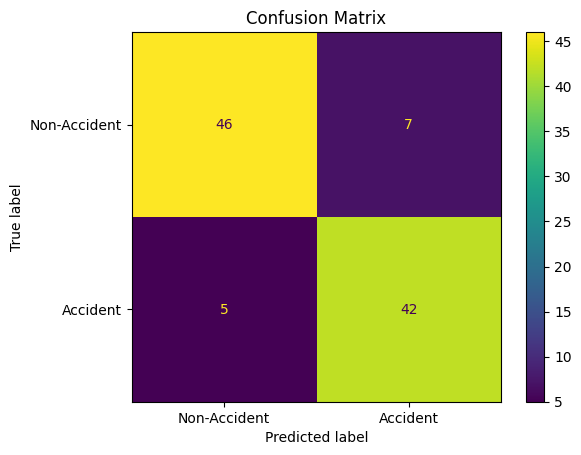


------------------------------------------------------------------------------------------



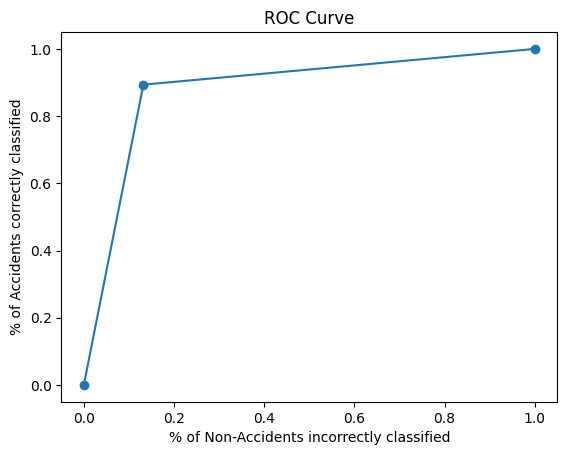


------------------------------------------------------------------------------------------

AUC score is: 0.88


In [55]:
clf.fit(X_train_gray_sc, y_train_final)
pred_gray_val = clf.predict(X_test_gray_sc)
calculate_metrics(pred_gray_val, y_test)

So, the best we could do using **Adaboost** is a validation fbeta score (beta = 1.4) of 0.88, with the parameters:

- random_state: 5000
- estimator: DecisionTreeClassifier(max_depth = 1)
- learning_rate: 0.7
- n_estimators: 300